Package imports and dataset download

1.- Buscar un nuevo dataset publico entre 3 a 10 clases, que tenga no mas de 1’000’000 de puntos de data y no menos de 50’000. No puedes usar MNIST, pero si otras bases de datos asocidadas a MNIST : Ejemplo: Fashion MNIST. Si fuera conveniente puedes re-scalar tu dataset a 32x32x3 si las imagenes originales son muy grandes, y dejar que ese sea tu nueva data en bruto. Deberas declarar la dimensionalidad de tu data en bruto. Por ejemplo: si las imagenes son de 32x32x3, la dimensionalidad es de 3072. Plotear 10 ejemplos de imagenes usadas en tu dataset – por lo menos 1 por clase

In [8]:
import clip
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from torch import pca_lowrank, tensor, float32, cuda, no_grad, cat
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [9]:

cifar10 = CIFAR10(root='../data', train=True, download=True)
dataset = tensor(cifar10.data.copy().reshape(cifar10.data.shape[0], -1), dtype=float32)

Files already downloaded and verified


Plotting one image per class (32x32x3 dimensionality is 3072)

Plotear 10 ejemplos de imagenes usadas en tu dataset – por lo menos 1 por clase

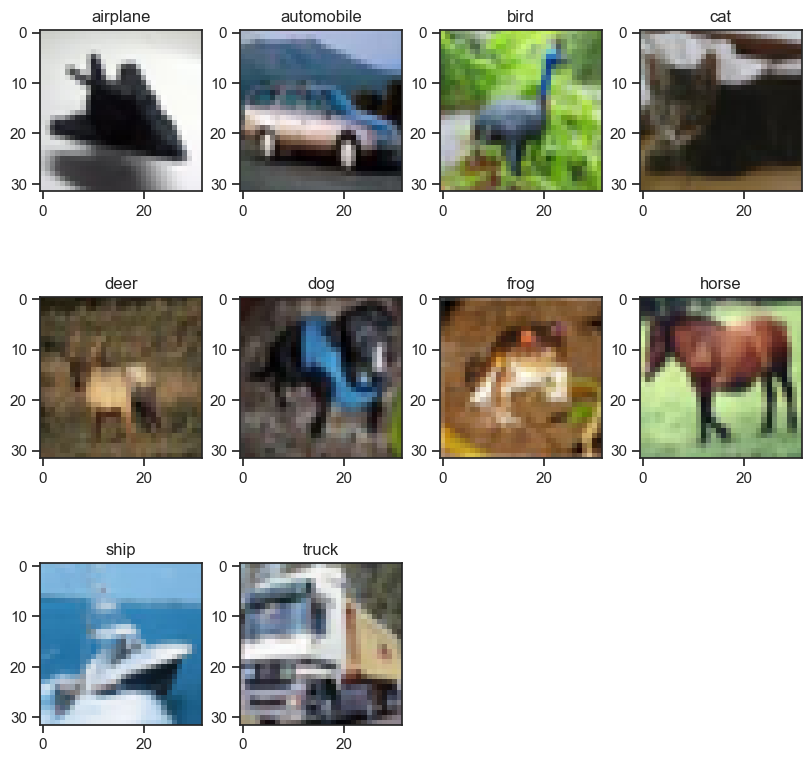

In [10]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
columns = 4
rows = 3

for img_class in range(10):
    img = cifar10.data[cifar10.targets.index(img_class)]
    fig.add_subplot(rows, columns, img_class + 1, title=cifar10.classes[img_class])
    plt.imshow(img)

2.- Proyectar tu dataset (data en bruto) a dos dimensiones usando PCA, y visualizar/plotear el dataset con un codigo de colores dependiendo de las clases. Plotear los dos eigenvectors tambien.

/Users/leonardocandio/.conda/envs/lab3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, '2D PCA of CIFAR10 dataset')

<Figure size 1500x1500 with 0 Axes>

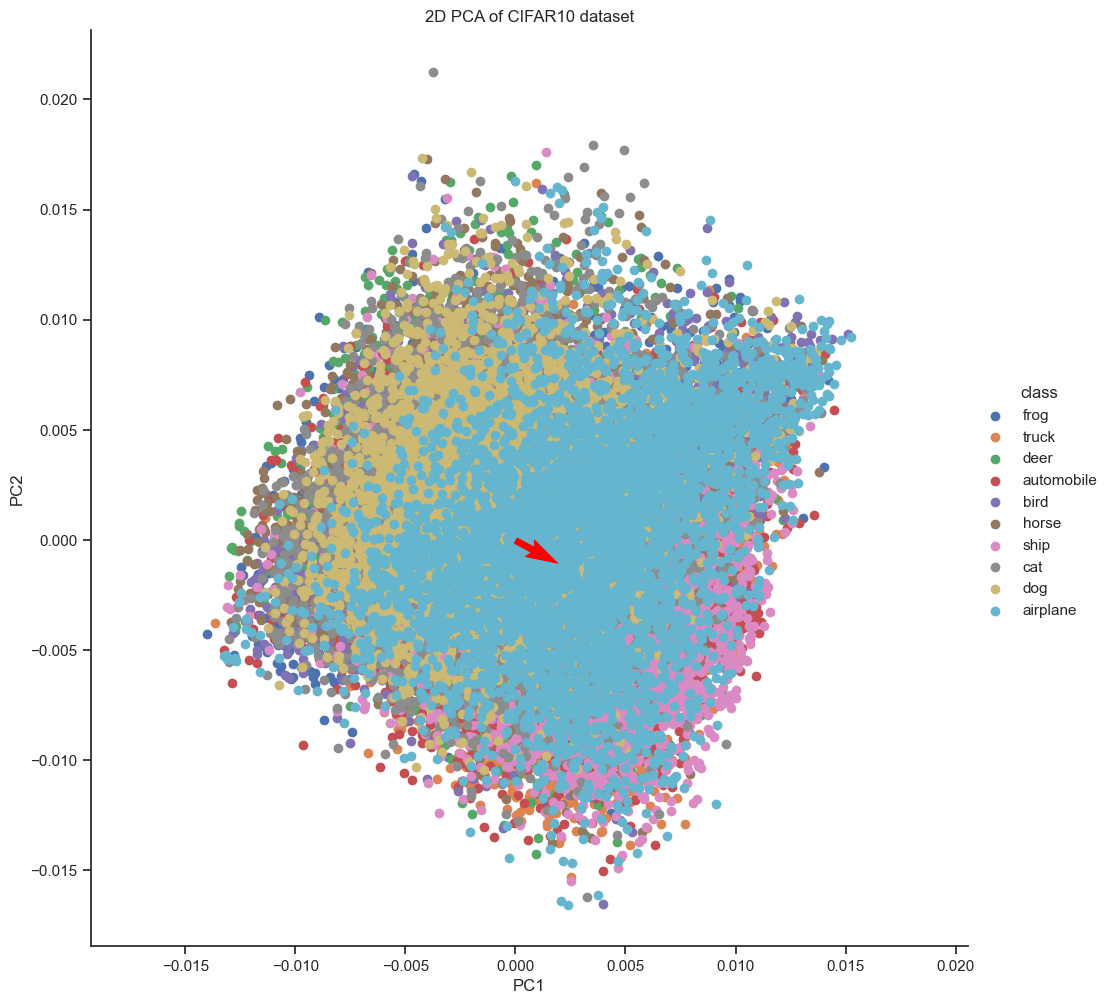

In [11]:
pcaU, pcaS, pcaV = pca_lowrank(dataset, 2)

sns.set(style="ticks")

pcaU = pd.DataFrame(pcaU, columns=['PC1', 'PC2'])
pcaU['class'] = [cifar10.classes[target] for target in cifar10.targets]

#using seaborn to plot the data
plt.figure(figsize=(15, 15))
sns.FacetGrid(pcaU, hue="class", height=10).map(plt.scatter, "PC1", "PC2").add_legend()

# add eigenvectors

for length, vector in zip(pcaS, pcaV):
    v = vector * length
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', color='red')
plt.axis('equal')
plt.title('2D PCA of CIFAR10 dataset')


3.- Repetir el paso anterior usando primero un embedding de tu eleccion y luego aplicar PCA al dataset hacia dos dimensiones.Visualizar/plotear el dataset con un codigo de colores dependiendo de las clases. Deberas declarar la dimension del embedding.

In [12]:
#Image embedding using CLIP
device = "cuda" if cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
cifar10embedded = CIFAR10(root='../data', train=True, download=True, transform=preprocess)
embedded_dataset = []

with no_grad():
    for image, class_id in tqdm(DataLoader(cifar10embedded, batch_size=100)):
        image_features = model.encode_image(image)
        embedded_dataset.append(image_features.to(device))
embedded_dataset = cat(embedded_dataset)

Files already downloaded and verified


100%|██████████| 500/500 [16:02<00:00,  1.93s/it]


/Users/leonardocandio/.conda/envs/lab3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, '2D PCA using CLIP embedding of CIFAR10 dataset')

<Figure size 1500x1500 with 0 Axes>

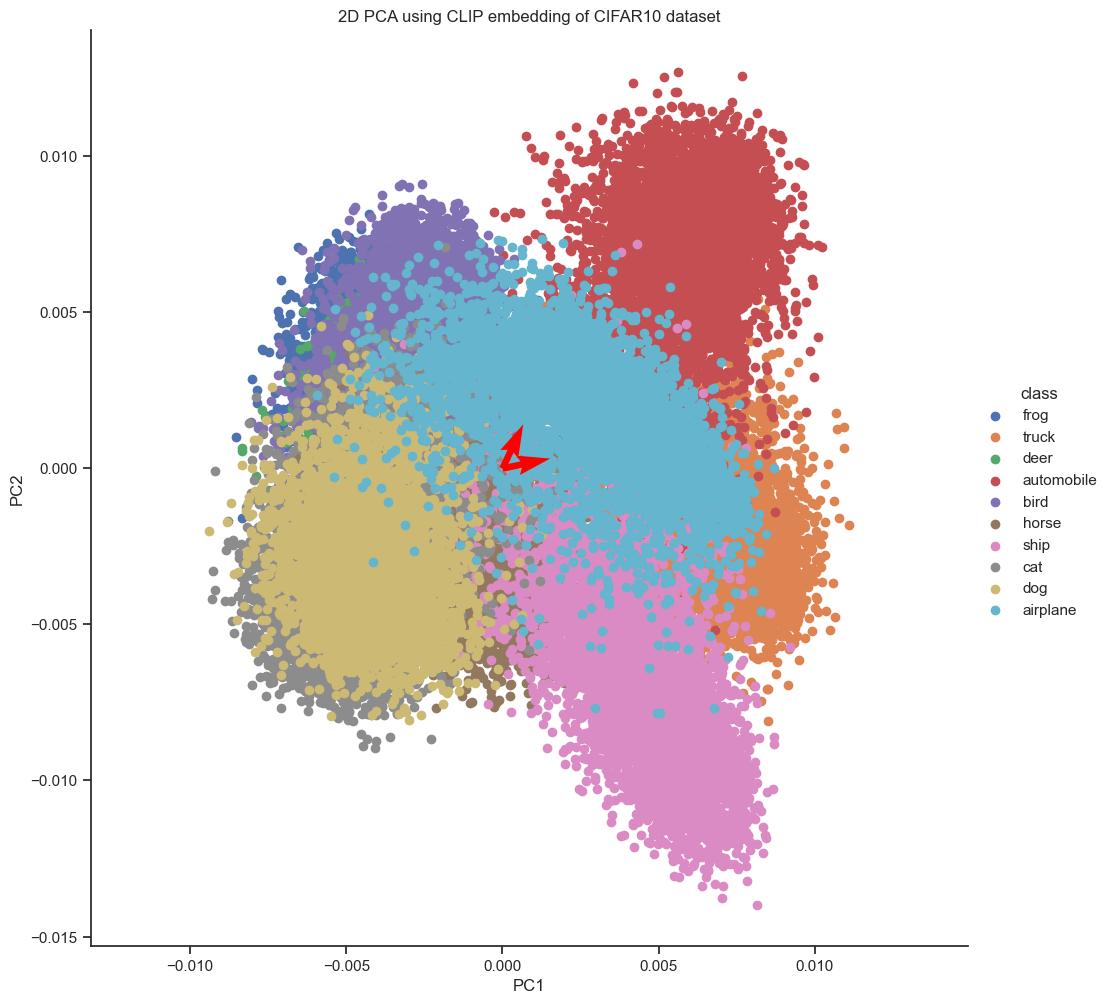

In [13]:
#Plotting the embedded dataset using PCA
pcaU_embedded, pcaS_embedded, pcaV_embedded = pca_lowrank(embedded_dataset, 2)

sns.set(style="ticks")

pcaU_embedded = pd.DataFrame(pcaU_embedded, columns=['PC1', 'PC2'])
pcaU_embedded['class'] = [cifar10.classes[target] for target in cifar10.targets]

#using seaborn to plot the data
plt.figure(figsize=(15, 15))
sns.FacetGrid(pcaU_embedded, hue="class", height=10).map(plt.scatter, "PC1", "PC2").add_legend()

for length, vector in zip(pcaS_embedded, pcaV_embedded):
    v = vector * length
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', color='red')
plt.axis('equal')
plt.title('2D PCA using CLIP embedding of CIFAR10 dataset')

4.- Proyectar tu dataset (data en bruto) a dos dimensiones usando t-SNE, y visualizar/plotear el dataset con un codigo de colores dependiendo de las clases.

In [14]:
#Calculating t-SNE

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results_pca = tsne.fit_transform(dataset)

/Users/leonardocandio/.conda/envs/lab3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, '2D t-SNE of CIFAR10 dataset')

<Figure size 1500x1500 with 0 Axes>

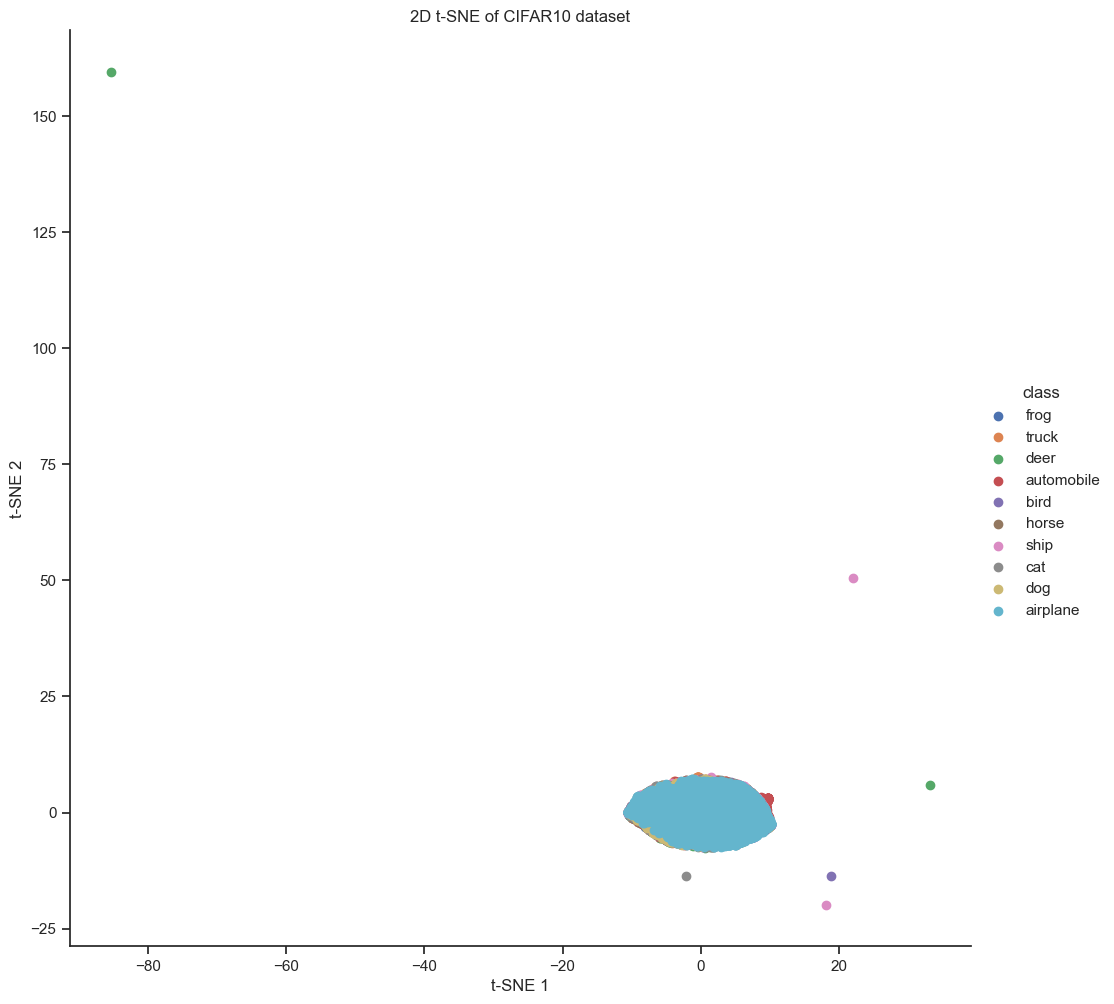

In [15]:
#TODO PREGUNTAR PORQUE SE VE TAN MAL

plt.figure(figsize=(15, 15))
tsne_results_pca = pd.DataFrame(tsne_results_pca, columns=['t-SNE 1', 't-SNE 2'])
tsne_results_pca['class'] = [cifar10.classes[target] for target in cifar10.targets]

sns.FacetGrid(tsne_results_pca, hue="class", height=10).map(plt.scatter, 't-SNE 1', 't-SNE 2').add_legend()
plt.title('2D t-SNE of CIFAR10 dataset')

5.- Repetir el paso anterior usando primero un embedding de tu eleccion y luego aplicar t-SNE al dataset hacia dos dimensiones. Visualizar/plotear el dataset con un codigo de colores dependiendo de las clases. Deberas declarar la dimension del embedding.

In [16]:
tsne_embedded = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results_embedded = tsne_embedded.fit_transform(embedded_dataset)

/Users/leonardocandio/.conda/envs/lab3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, '2D t-SNE using CLIP embedding of CIFAR10 dataset')

<Figure size 1500x1500 with 0 Axes>

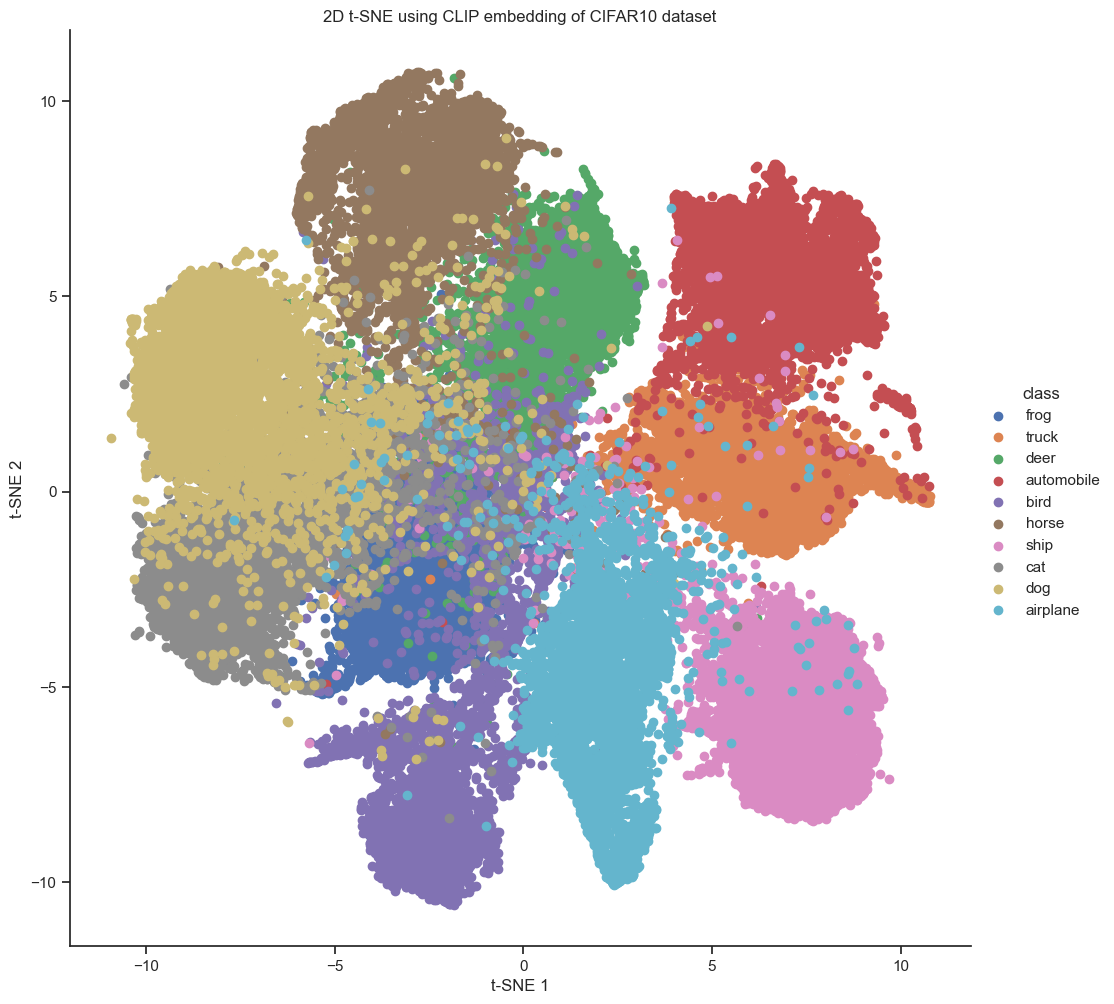

In [17]:
plt.figure(figsize=(15, 15))
tsne_results_embedded = pd.DataFrame(tsne_results_embedded, columns=['t-SNE 1', 't-SNE 2'])
tsne_results_embedded['class'] = [cifar10.classes[target] for target in cifar10.targets]

sns.FacetGrid(tsne_results_embedded, hue="class", height=10).map(plt.scatter, 't-SNE 1', 't-SNE 2').add_legend()
plt.title('2D t-SNE using CLIP embedding of CIFAR10 dataset')

6.- Aplicar K-Means (elegir K como cualquier valor entre 3 y 10 dependiendo del numero de clases en tu dataset), y clusterizar la data que esta proyectada en 2-D asumiendo que no tienes acceso a los labels. Plotear los clusters en codigos de color para los siguientes casos: PCA, Embedding-PCA, t-SNE y Embedding-t-SNE. Deberias tener 4 plots. Que clusters se ven mejor para ti? Por que?

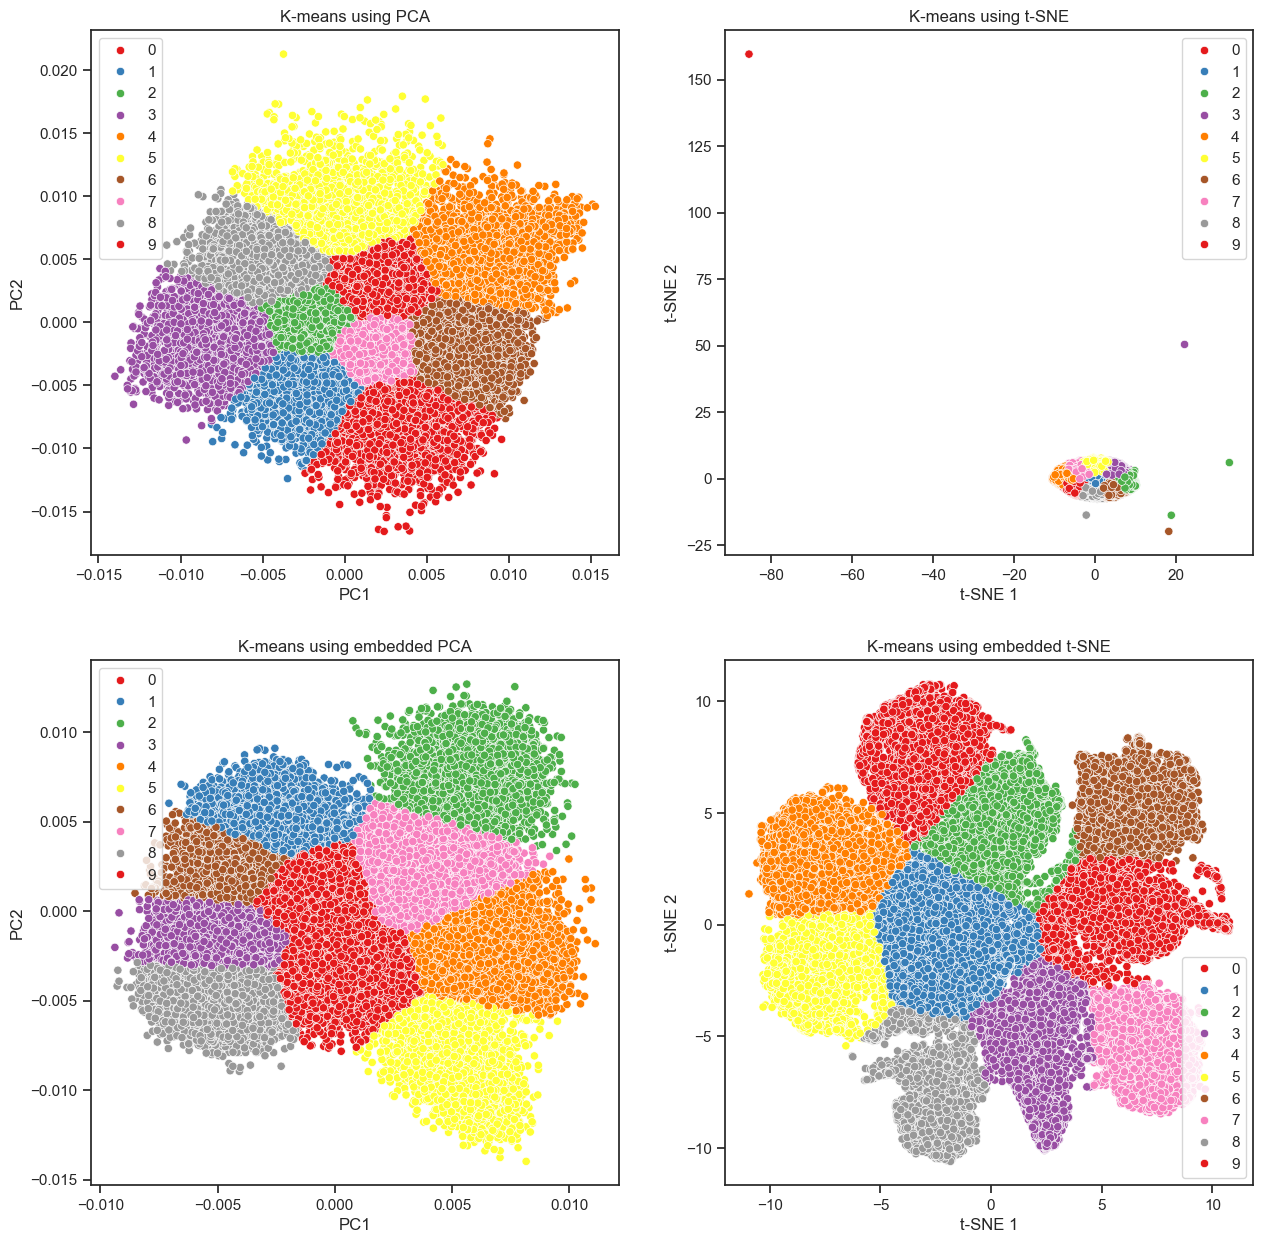

In [19]:
#K-means for PCA
kmeans_pca = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_pca.fit(pcaU[['PC1', 'PC2']])

#K-means for t-SNE
kmeans_tsne = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_tsne.fit(tsne_results_pca[['t-SNE 1', 't-SNE 2']])

#K-means for embedded PCA
kmeans_embedded = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_embedded.fit(pcaU_embedded[['PC1', 'PC2']])

#K-means for embedded t-SNE
kmeans_embedded_tsne = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans_embedded_tsne.fit(tsne_results_embedded[['t-SNE 1', 't-SNE 2']])

#plot all the clusters in the same image

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue=kmeans_pca.labels_, data=pcaU, palette='Set1')
plt.title('K-means using PCA')
plt.subplot(2, 2, 2)
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue=kmeans_tsne.labels_, data=tsne_results_pca, palette='Set1')
plt.title('K-means using t-SNE')
plt.subplot(2, 2, 3)
sns.scatterplot(x='PC1', y='PC2', hue=kmeans_embedded.labels_, data=pcaU_embedded, palette='Set1')
plt.title('K-means using embedded PCA')
plt.subplot(2, 2, 4)
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue=kmeans_embedded_tsne.labels_, data=tsne_results_embedded, palette='Set1')
plt.title('K-means using embedded t-SNE')
plt.show()


7.- Aplicar Mean-Shift con un Gaussian Kernel y clusterizar la data que esta proyectada en 2-D asumiendo que no tienes acceso a los labels. Plotear los clusters en codigos de color para los siguientes casos: PCA, Embedding-PCA, t-SNE y Embedding-t-SNE. Deberias tener 4 plots. Que clusters se ven mejor para ti? Por que?

8.- Que algoritmo clusterizo la data mejor: K-Means o Mean-Shift? Por que? Cuanto crees que esto depende de PCA vs t-SNE o del tipo de embedding o de la data en bruto?